## Parameters

In [1]:
data_loc = "saved/mnist_rot" # location of input data
save_loc = "saved/mnist_rot" # location to save to (can be the same as above)

### Full version ###

reps = 5 # number of trials to run for each model
epochs = 100  # max number, may stop early if no improvment 
early_stop = 4 # stop if no improvement in this many epochs
save_all_models = False
batch_size = 32
latent_dim_options = [6,8,12]



### Quick version ###

reps = 1 
epochs = 2 
early_stop = 2 # stop if no improvement in this many epochs
save_all_models = False
batch_size = 32
latent_dim_options = [8]

## Imports

In [2]:
import numpy as np
from scipy import ndimage
from my_lib.save_load import load_datasets, save_models
from my_lib.models.common_functions import sampling

import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

import tensorflow as tf

## Load Data 

In [3]:
all_data = load_datasets(data_loc)

for name, model in all_data.items():
    name = name.split(".")[0]
    exec("{} = model".format(name))
    print("initialized variable,", name)

initialized variable, rots_train
initialized variable, y_train
initialized variable, rots_test
initialized variable, y_test
initialized variable, x_test
initialized variable, x_train


# Vae

In [4]:

def make_cvae(latent_dim = 8):
    """
    Creates a convolutional variational autoencoder
    
    :param latent_dim: (int) size of latent dimension
    
    """
    in_enc = Input(shape=(28, 28, 1), name="encoder_inputs")

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides=2, activation='relu')(in_enc)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(2, 2), strides=2, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024,  activation='relu')(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(in_enc, [z_mean, z_log_var, z], name='encoder')




    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

    x = tf.keras.layers.Dense(units=1024, activation="relu")(latent_inputs)
    base= 7
    x = tf.keras.layers.Dense(units=base*base*128, activation="relu")(x)
    x = tf.keras.layers.Reshape(target_shape=(base, base, 128))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=2, padding='same', activation='relu')(x)
    output = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=1, padding='same', activation='sigmoid')(x)
    # outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, output, name='decoder')
    # decoder.summary()
    # plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

    # instantiate VAE model
    outputs = decoder(encoder(in_enc)[2])
    vae = Model(in_enc, outputs, name='vae_mlp')
    
    mse_loss = mse(in_enc, outputs)
    image_size = x_train.shape[1]
    original_dim = image_size * image_size
    mse_loss *= original_dim
#     p_loss = -log_normal_pdf(in_enc, outputs, logvar=0., raxis=(1,2,3))
    
    reconstruction_loss = mse_loss
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae_loss = tf.reduce_mean(reconstruction_loss) + tf.reduce_mean(kl_loss)
    
    vae.add_metric(kl_loss, name="kl_loss", aggregation="mean")
    
    vae.add_metric(reconstruction_loss, name="reconstruction_loss", aggregation="mean")

    
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    return vae, encoder, decoder

In [5]:
vae, encoder, decoder = make_cvae()

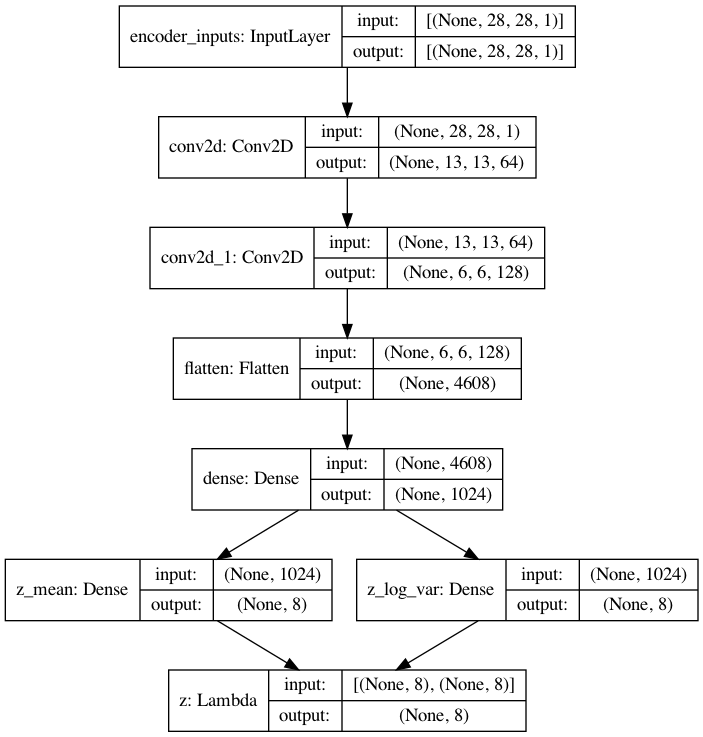

In [6]:
plot_model(encoder, to_file='models/encoder_rot.png', show_shapes=True)

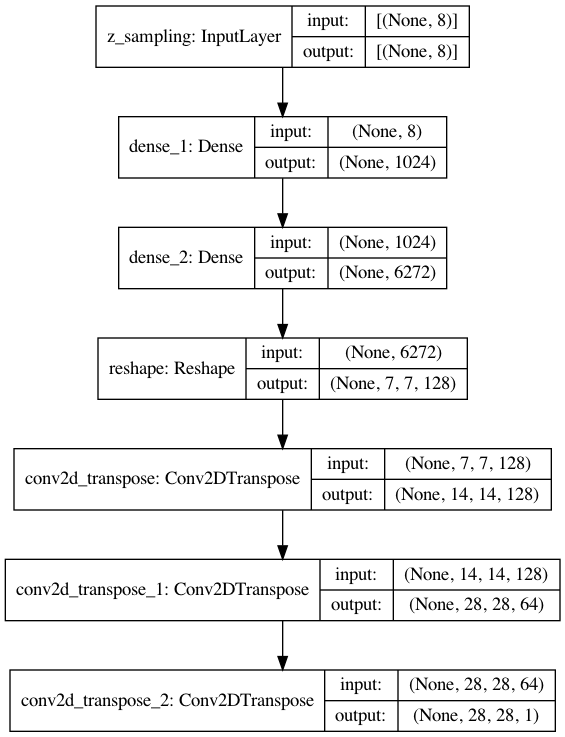

In [7]:
plot_model(decoder, to_file='models/decoder_rot.png', show_shapes=True)

In [8]:
if np.max(x_test) > 200:
    x_train = x_train/255.
    x_test = x_test/255.

### Run multiple times to determine best latent dimesion (ld)

In [9]:
trained = []

In [10]:


for rep in range(reps):
    for ld in latent_dim_options:
        
        cb = tf.keras.callbacks.EarlyStopping(
            monitor='val_reconstruction_loss', patience=early_stop, restore_best_weights=True
        )

        
        vae, encoder, decoder = make_cvae(ld)
        
        id_str = "{}_{}".format(ld, rep)
        print("\n\n", id_str)
        trained.append((id_str, vae, encoder, decoder))

        vae.fit(x_train,
                epochs=epochs,
                batch_size=32,
                callbacks=[cb],
                validation_data=(x_test, None))

        save_loc = "digits_{}d_{}_thick".format(ld, rep)
        models = (vae, encoder, decoder)
        
        if save_all_models:
            save_models(save_loc, models)
            print("Saved model to", save_loc)
        
        



 8_0
Epoch 1/2
1875/1875 [==============================] - 239s 127ms/step - loss: 46.9175 - kl_loss: 7.2427 - reconstruction_loss: 32.6078 - val_loss: 34.4266 - val_kl_loss: 10.1221 - val_reconstruction_loss: 24.3020
Epoch 2/2
1875/1875 [==============================] - 234s 125ms/step - loss: 34.0047 - kl_loss: 10.2028 - reconstruction_loss: 23.3944 - val_loss: 32.9518 - val_kl_loss: 9.6697 - val_reconstruction_loss: 23.2815


### View Results

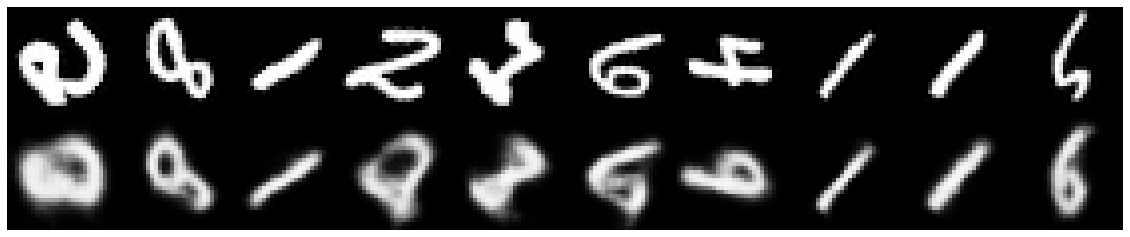

  0.214          0.153          0.102          0.152          0.176          0.125          0.147          0.071          0.102          0.101


In [11]:
from tensorflow.keras.losses import MSE
def check_recons(vae, test_samples):
    
    digit_size = 28
    figure = np.zeros((digit_size * 2, digit_size * len(test_samples), 1))
    
    recons = vae(test_samples)

    
    for r, (img1, img2) in enumerate(zip(test_samples, recons)):
        for c, img in enumerate([img1, img2]):
            
            if len(img.shape) < 3:
                img = np.expand_dims(img, -1) #tf.expand_dims(img, 1)

            figure[c * digit_size: (c + 1) * digit_size,
                   r * digit_size: (r + 1) * digit_size] = img
    
    plt.figure(figsize=(20,20))
    plt.imshow(np.squeeze(figure), cmap="Greys_r")
    plt.axis('off')
    plt.show()
    
    mses = []
    for i in range(len(test_samples)):
        x = tf.reduce_mean(MSE(test_samples[i], recons[i])).numpy()
        x = "{:.3f}".format(x)
        mses.append(x)

    s = " "*10
    print(" ", s.join(mses))
    
    
    return recons


n = 10
test_inds = np.random.choice(np.arange(len(x_test)),size=n, replace=False)
test_samples = x_test[test_inds]
check_recons(vae, test_samples);

In [12]:
vae.history.history.keys()

dict_keys(['loss', 'kl_loss', 'reconstruction_loss', 'val_loss', 'val_kl_loss', 'val_reconstruction_loss'])

Model id: 8_0
Best val_loss = 32.9517707824707


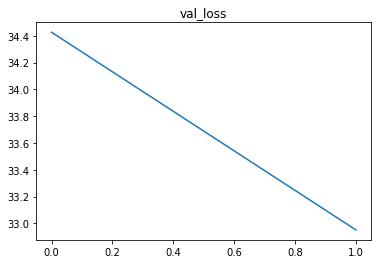

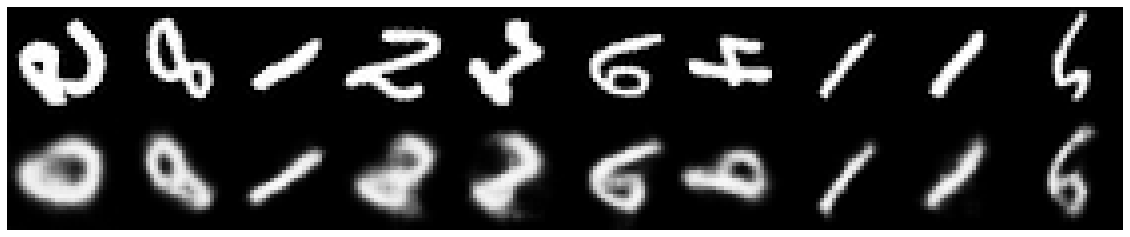

  0.211          0.154          0.108          0.166          0.175          0.129          0.144          0.070          0.096          0.082


In [13]:
show = 4
key = "val_loss"

def model_sort_key(x):
    try:
        id_str, model = x
        return min(model.track[key])
    except:
        return 1e10

    
    
for i, (id_str, vae, encoder, decoder) in enumerate(sorted(trained, key=model_sort_key)):
    print("Model id:", id_str)

    plt.plot(vae.history.history[key])
    print("Best", key, "=", min(vae.history.history[key]))
    plt.title(key)
    check_recons(vae, test_samples)
        
    plt.show()
        

## Save models

In [14]:
find = "6_0"


for id_str, vae, encoder, decoder in trained:

    if id_str == find:
        print(id_str)
        print(min(vae.history.history["val_loss"]))
        plt.plot(vae.history.history["val_loss"])
        plt.show()
        
        print("found")
        break
    

In [15]:

models = (vae, encoder, decoder)
save_models(save_loc, models)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: digits_8d_0_thick/models/vae_mlp/assets
INFO:tensorflow:Assets written to: digits_8d_0_thick/models/encoder/assets
INFO:tensorflow:Assets written to: digits_8d_0_thick/models/decoder/assets


### View VAE latent space

In [20]:

def normal_fill(vals, inds, size, mean=0, sd=1):
    norm_filled = np.random.normal(size=size, loc=mean, scale=sd)
    for i, v in enumerate(inds):
        norm_filled[v] = vals[i]
    return norm_filled.reshape((-1, size))



def sp_results(models,
                 data,
                 dims = [0,1],
                 sd = 0.1,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, dims[0]], z_mean[:, dims[1]], c=y_test)
    plt.colorbar()
    plt.xlabel("z[{}]".format(dims[0]))
    plt.ylabel("z[{}]".format(dims[1]))
    plt.show()
    
    
    
def walk_ld(models,
                 dims = [0,1],
                 sd = 0.1,
                 batch_size=128,
                 model_name="vae_mnist"):
    
    encoder, decoder = models


    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    
    
    ldim = decoder.layers[0].input_shape[0][1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):

            z_sample = normal_fill([xi,yi], dims, ldim)
            
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[{}]".format(dims[0]))
    plt.ylabel("z[{}]".format(dims[1]))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    

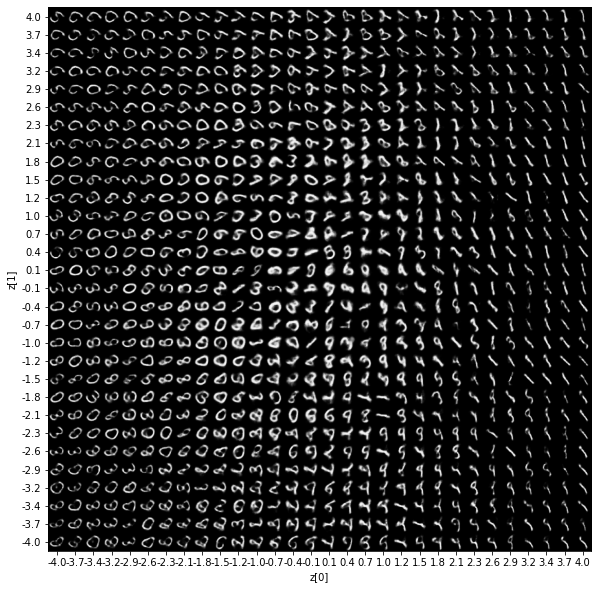

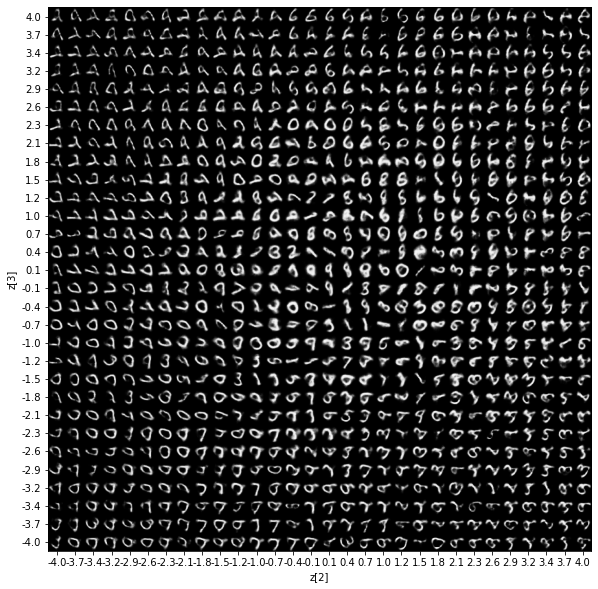

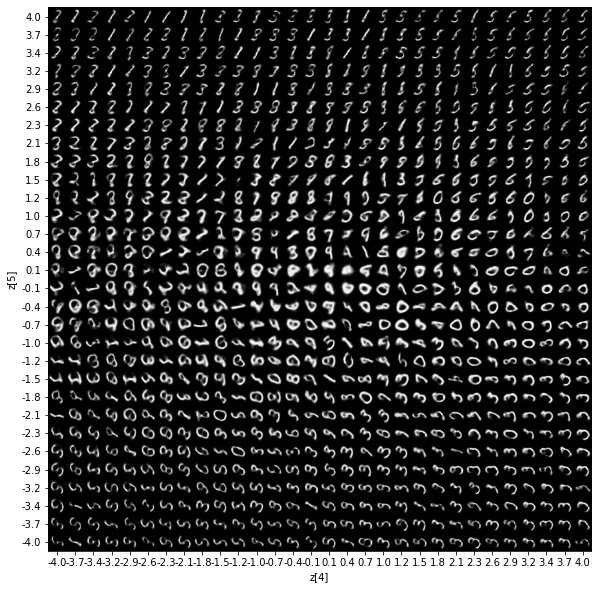

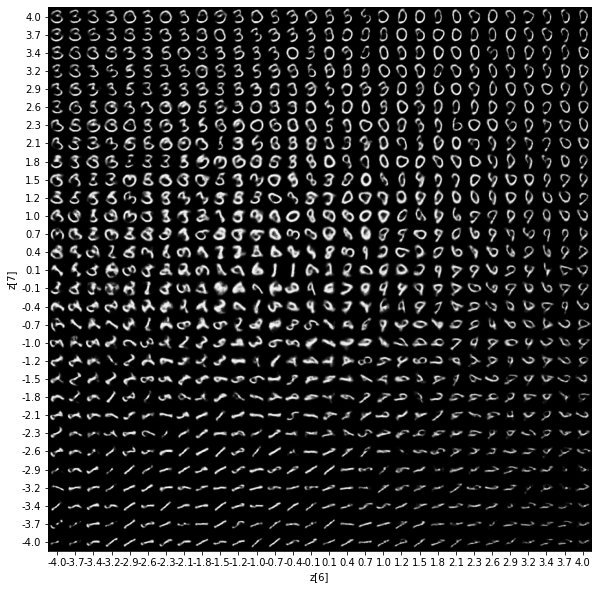

In [21]:
latent_dim = decoder.layers[0].input_shape[0][1]
for i in range(0, latent_dim, 2):
    walk_ld(models[1:], dims=[i, i+1])

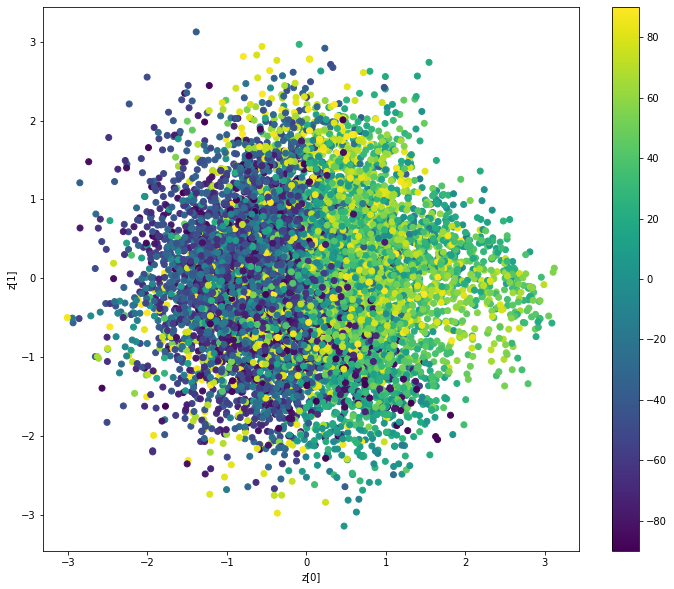

In [22]:
sp_results(models[1:],
             (x_test, rots_test),
             batch_size=batch_size,
             model_name="vae_mlp_ld{}".format(latent_dim))

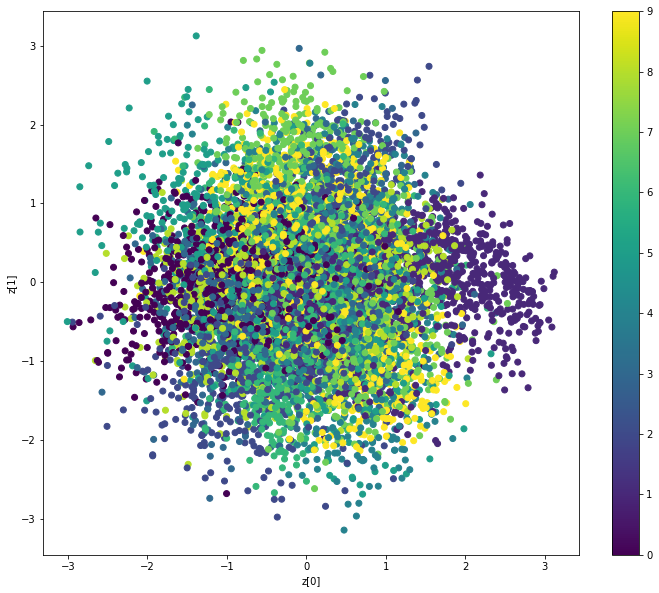

In [23]:
sp_results(models[1:],
             (x_test, y_test),
             batch_size=batch_size,
             model_name="vae_mlp_ld{}".format(latent_dim))